In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)
    
sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
107,Z:\Data\FujisawaS\EE\EE0705fm
108,Z:\Data\FujisawaS\EE\EE0706fm
109,Z:\Data\FujisawaS\EE\EE0708fm
110,Z:\Data\HMC1\day12


In [ ]:
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\predict_downstream_pairs_v1"
# )

# batch_analysis.run(
#     df_sessions,
#     save_path,
#     predict_downstream.run,
#     parallel=True,
#     verbose=True,
# )
# # load results
# results = predict_downstream.load_results(save_path)

In [3]:
basepath = r"Z:\Data\HMC1\day8"
# basepath = r"Z:\Data\AYAold\AYA9\day14"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [4]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]

In [23]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="firing_rate",
)

In [7]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

In [53]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LinearRegression, RidgeCV

X = st_par[cell_metrics.brainRegion.str.contains("MEC").values, :]
# # get pca dims that explain XX of the variance
X = PCA(n_components=0.80, svd_solver="full").fit_transform(X.T)

y = st_par[ca1_deep_idx,:][4,:]
# bad_idx = np.hstack(np.isinf(y) | np.isnan(y))
# y = y[~bad_idx]
# X = X[~bad_idx, :]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

clf = RidgeCV().fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.042625781370491334
0.008360100345581545


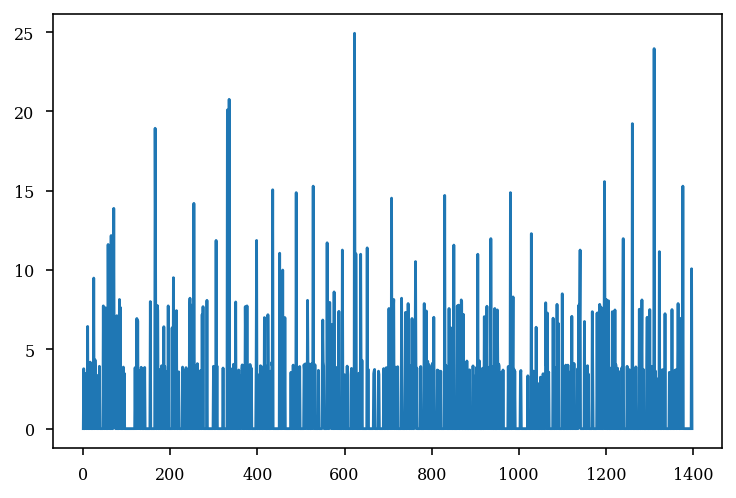

In [44]:
plt.plot(y_train)

(0.0, 50.0)

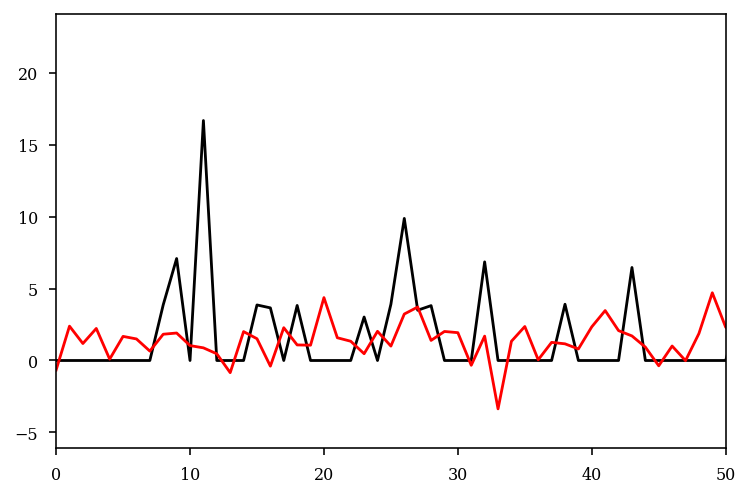

In [45]:
plt.plot(y_test,color="k")

plt.plot(clf.predict(X_test), color="red")
plt.xlim(0,50)

In [55]:
from pyglmnet import GLM

glm_poisson = GLM(distr='poisson',
                  alpha=0.05,
                  learning_rate=1.0,
                  score_metric='pseudo_R2',
                  reg_lambda=1e-7)
glm_poisson.fit(X_train, y_train)

# predict spike counts
# ypred_lg = glm_poisson.predict(X_test)

<
Distribution | poisson
alpha | 0.05
max_iter | 1000.00
lambda: 0.00
>

(0.0, 50.0)

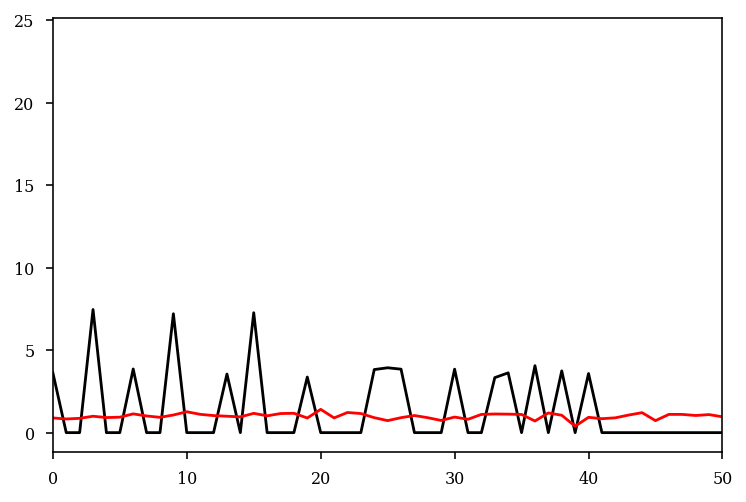

In [56]:
plt.plot(y_test,color="k")

plt.plot(glm_poisson.predict(X_test), color="red")
plt.xlim(0,50)


In [6]:
bst = st[ripple_epochs].bin(ds=0.02)


In [172]:
X = bst.data.copy()

X = scaler.fit_transform(X)

In [30]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

# bst = st[ripple_epochs].bin(ds=0.02)

# X = bst.data.copy()
X = st_par.copy()
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(X)


ca1_deep_idx = cell_metrics.brainRegion.str.contains("CA1").values & (cell_metrics.deepSuperficial == "Deep")
ca1_sup_idx = cell_metrics.brainRegion.str.contains("CA1").values & (cell_metrics.deepSuperficial == "Superficial")

# X_ca1 = PCA().fit_transform(X[ca1_idx ,:].T)

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_deep_idx,:].T, 
    X[cell_metrics.brainRegion.str.contains("PFC").values,:].T, test_size=0.4, random_state=42
)

In [35]:
from ripple_heterogeneity.utils import (
    reduced_rank_regressor,
    system_identifier,
    multivariate_regressor,
)
from scipy import around
from scipy import size
from scipy.linalg import norm

def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, 'fro'), 2) / size(matrix2, 0), 5)

RANK = 10
REG = 1e-6                      # regularization on the model

reg = reduced_rank_regressor.ReducedRankRegressor(
    X_train,
    y_train,
    RANK,
    REG
)
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
print(training_error, testing_error)

reg = multivariate_regressor.MultivariateRegressor(
    X_train,
    y_train,
    REG,
)
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
print(training_error, testing_error)


sys_id = system_identifier.SystemIdentifier(X_train,
    y_train,
    RANK,
    REG)
training_error = sqerr(sys_id.predict(X_train), y_train)
testing_error = sqerr(sys_id.predict(X_test), y_test)
print(training_error, testing_error)


45.82737 46.24463
45.15887 46.68987
44.10305 45.71149


(0.0, 100.0)

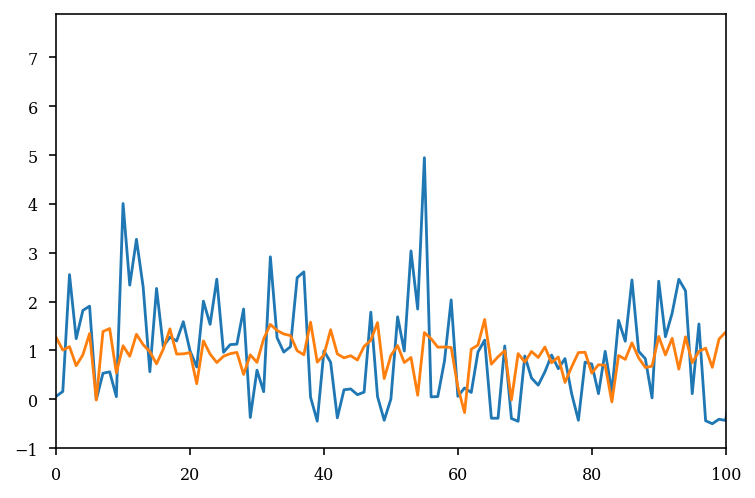

In [32]:
plt.plot(y_train[:,3])
plt.plot(reg.predict(X_train)[:,3])

plt.xlim(0,100)

In [113]:
sys_id = system_identifier.SystemIdentifier(X_train,
    y_train,
    RANK,
    REG)
training_error = sqerr(sys_id.predict(X_train), y_train)
testing_error = sqerr(sys_id.predict(X_test), y_test)
training_error, testing_error


(37.3465, 42.8783)

In [106]:
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
training_error, testing_error

(40.18082, 42.92914)

<AxesSubplot:>

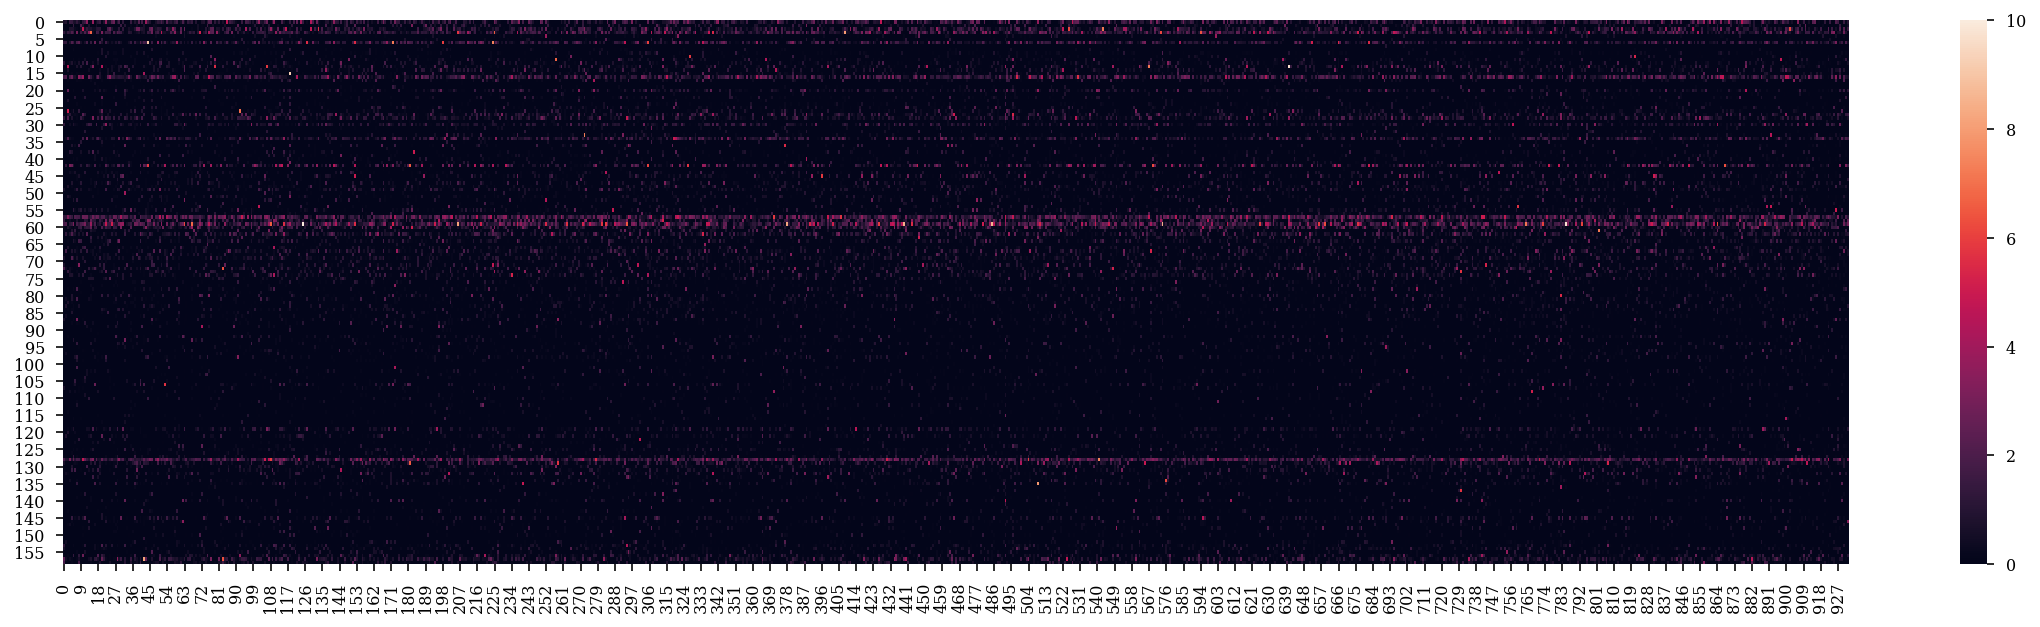

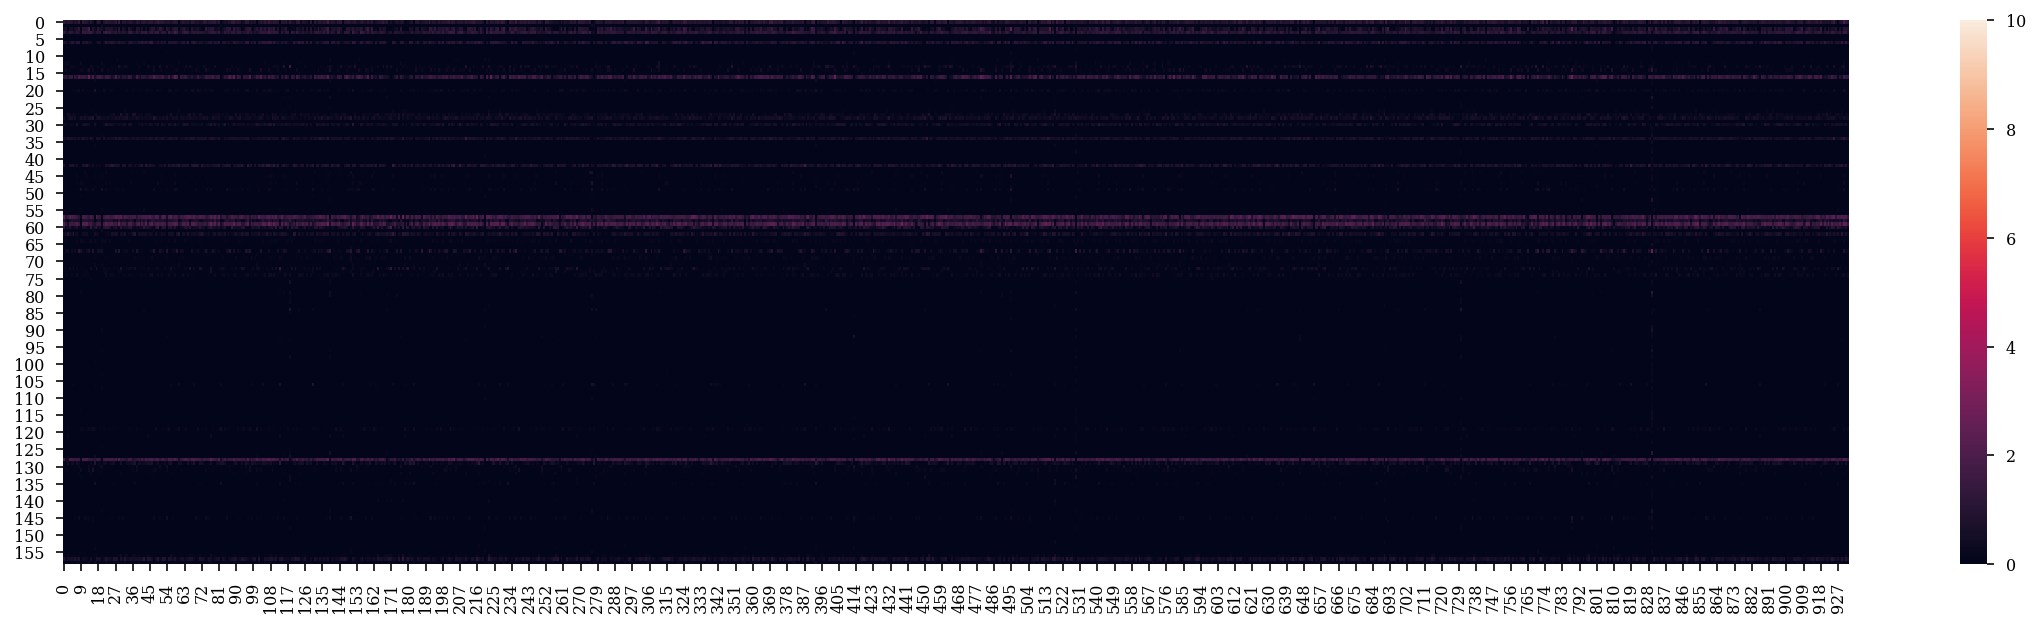

In [126]:

plt.figure(figsize=(20,5))
sns.heatmap(y_test.T,vmin=0,vmax=10)
plt.figure(figsize=(20,5))
sns.heatmap(reg.predict(X_test).T,vmin=0,vmax=10)

In [96]:
"""Machine learning with linear models - a demo
Requires scipy to be installed.
Implemented by Chris Rayner (2015)
dchrisrayner AT gmail DOT com
My Ph.D. supervisor Dr. Michael Bowling introduced me to RRR; Dr. Tijl De Bie
gave a great talk on subspace system identification in 2005 that I modeled my
implementation on: http://videolectures.net/slsfs05_bie_slasi/
"""

# import multivariate_regressor
# import reduced_rank_regressor
# import system_identifier

from scipy import around
from scipy import size
from scipy.linalg import norm
from numpy.random import seed

DIM_X = 20                      # dimensionality of input
DIM_Y = 15                      # dimensionality of output
RANK = 10                       # internal rank/bottleneck
NOISE_SCALE = 1.0
NUM_SAMPLES = 5000
SPLIT = int(NUM_SAMPLES/2)      # train/test split
REG = 1e-6                      # regularization on the model


def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, 'fro'), 2) / size(matrix2, 0), 5)


if __name__ == '__main__':
    seed(10)
    for model in [multivariate_regressor, reduced_rank_regressor, system_identifier]:
        # generate the data:
        print(model.ideal_data.__doc__)
        XX, YY = model.ideal_data(NUM_SAMPLES, DIM_X, DIM_Y, RANK, NOISE_SCALE)
        # run each of the regressors against it:
        for regressor in ([
                multivariate_regressor.MultivariateRegressor(XX[:SPLIT], YY[:SPLIT], REG),
                reduced_rank_regressor.ReducedRankRegressor(XX[:SPLIT], YY[:SPLIT], RANK, REG),
                system_identifier.SystemIdentifier(XX[:SPLIT], YY[:SPLIT], RANK, REG)]):
            print('  {}'.format(regressor))
            training_error = sqerr(regressor.predict(XX[:SPLIT]), YY[:SPLIT])
            testing_error = sqerr(regressor.predict(XX[SPLIT:]), YY[SPLIT:])
            print('    Training error: {}\n    Testing error: {}'
                  .format(training_error, testing_error))

Full rank data
  Multivariate Linear Regression
    Training error: 14.73986
    Testing error: 15.24806
  Reduced Rank Regressor (rank = 10)
    Training error: 29.60288
    Testing error: 30.80116
  Linear Dynamical System
    Training error: 14.72381
    Testing error: 15.36072
Low rank data
  Multivariate Linear Regression
    Training error: 14.78114
    Testing error: 14.86847
  Reduced Rank Regressor (rank = 10)
    Training error: 14.80385
    Testing error: 14.84956
  Linear Dynamical System
    Training error: 17.17712
    Testing error: 16.02869
Linear system data
  Multivariate Linear Regression
    Training error: 113.73439
    Testing error: 115.23946
  Reduced Rank Regressor (rank = 10)
    Training error: 131.07372
    Testing error: 133.97695
  Linear Dynamical System
    Training error: 23.75118
    Testing error: 23.32171


In [94]:
XX, YY = reduced_rank_regressor.ideal_data(NUM_SAMPLES, DIM_X, DIM_Y, RANK, NOISE_SCALE)
XX.shape,YY.shape

((5000, 20), (5000, 15))